In [1]:
%load_ext autoreload
%autoreload 3 --print

In [2]:
from kpsn.project.paths import Project, create_model
from kpsn.io import loaders
from kpsn.models import joint
from kpsn import config
from kpsn.models import instantiation, setup, pose, morph
from kpsn import fitting
from kpsn.models import util as model_util
from kpsn.io import alignment, features
from kpsn.fitting import em
from kpsn.io import utils as io_utils
from kpsn.fitting import methods
from kpsn.fitting import scans
from kpsn.io.armature import Armature
from kpsn.io.dataset import KeypointDataset, FeatureDataset
from kpsn import clouds
import os, sys, shutil
import numpy as np
import jax.numpy as jnp
from pprint import pprint
from kpsn.viz import model as viz_models
from kpsn.viz import util as viz_util
from kpsn.viz import styles
from kpsn import viz
plotter, colors = styles.init_nb("vscode_dark")

import glob
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import tqdm as tqdm
import jax.numpy.linalg as jla
import logging
logging.getLogger().setLevel(logging.INFO)

In [3]:
project_dir = '../projects/lrakp-notwild'
project = Project(project_dir)

# if os.path.exists(project_dir): shutil.rmtree(project_dir)
if not os.path.exists(project_dir):
    loaders.raw_npy.setup_project_config(
        project,
        filepaths = glob.glob(
            '../../../generative/datasets/lrakp_default/*.npy'),
        ref_session = 'subj0',
        keypoint_names = [
            'shldr', 'back', 'hips', 't_base', 'head',
            'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
            'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot'],
        keypoint_parents = [
            'back', 'hips', None, 'hips', 'shldr',
            'head', 'head', 'head', 'hips', 'lr_knee',
            'hips', 'rr_knee', 'shldr', 'shldr'])
    
    setup.setup_base_model_config(project)

In [4]:
cfg = config.load_project_config(project.main_config())
dataset = loaders.raw_npy.load(cfg["dataset"])

dataset, cfg = loaders.raw_npy.default_alignment.calibrate(
    project, dataset, cfg, origin="hips", anterior="head"
)

cfg = loaders.raw_npy.default_features.calibrate(project, dataset, cfg)
dataset, reduction_inverse = loaders.raw_npy.default_features._reduce(
    dataset, cfg["features"]
)
config.save_config(project.main_config(), cfg)

cfg = config.load_model_config(project.base_model_config())
cfg = pose.gmm.calibrate_base_model(project, dataset, cfg)
cfg = morph.lowrank_affine.calibrate_base_model(project, dataset, cfg)
cfg = em.calibrate_base_model(project, dataset, cfg)
config.save_model_config(project.base_model_config(), cfg)

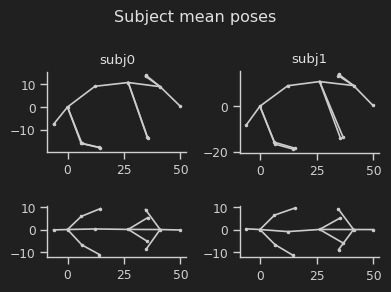

In [5]:
dataset = loaders.raw_npy.load(cfg["dataset"])
dataset_aligned, align_inverse = alignment.align(dataset, cfg["alignment"])
fig, ax = plt.subplots(
    2, dataset.n_sessions, figsize=(dataset.n_sessions * 2, 3)
)

for i, session in enumerate(dataset.sessions):
    viz_util.plot_mouse_views(
        ax[:, i],
        dataset.get_session(session).mean(axis=0),
        Armature.from_config(cfg["dataset"]),
        color=colors.neutral,
        specialkp=None,
    )
    ax[0, i].set_title(session)

fig.suptitle("Subject mean poses")
plotter.finalize(fig, None)

### Prior scan

In [4]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "prior-scan", {
    'morph.upd_var_ofs': [1e-1, 1e0, 1e1],
    'morph.upd_var_modes': [1e-2, 1e-1, 1e2],
}, model_overrides={
    'fit.learning_rate': 8,
    'fit.n_steps': 70,
})

scans.run_scan(project, "prior-scan", log_every=1, force_restart=True)

INFO:root:Removing existing model ../projects/lrakp-notwild/models/prior-scan_0
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kaifox/bin/miniconda3/envs/kpsn-dev/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 1198 frames
INFO:root:Adjusting learning rate:8 -> 0.0016701461377870565
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 349656.625

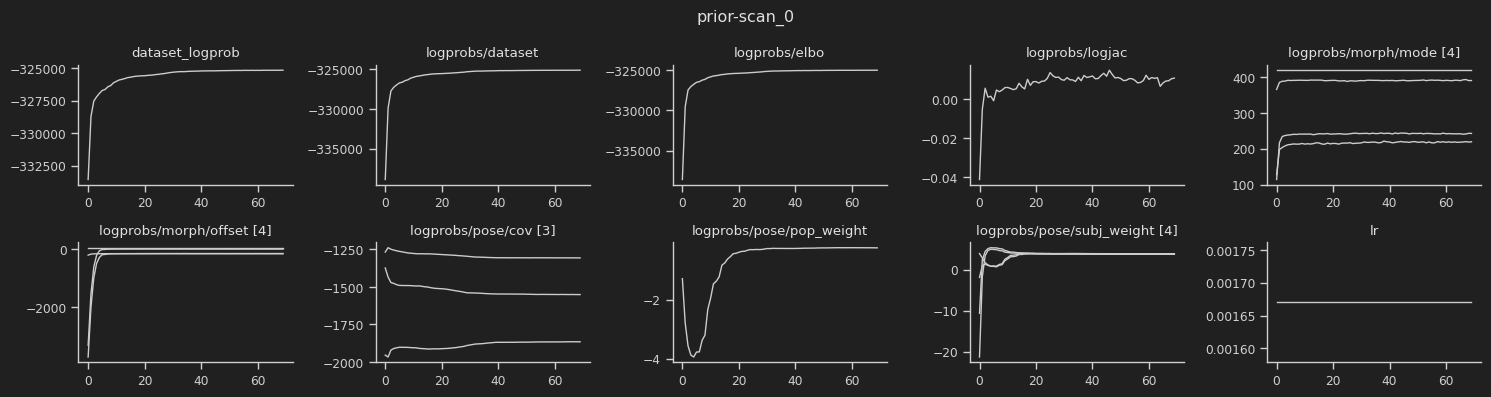

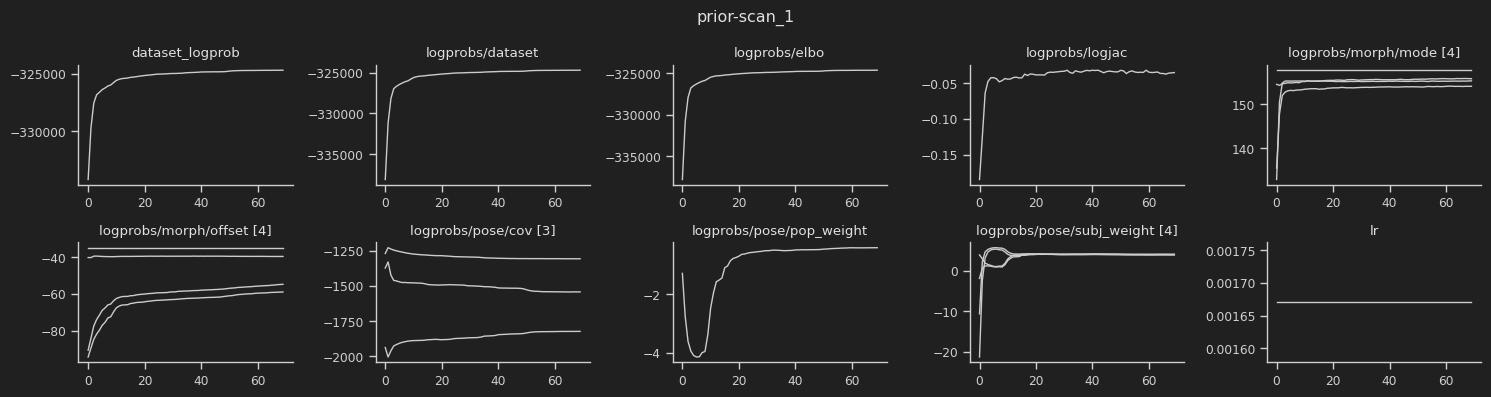

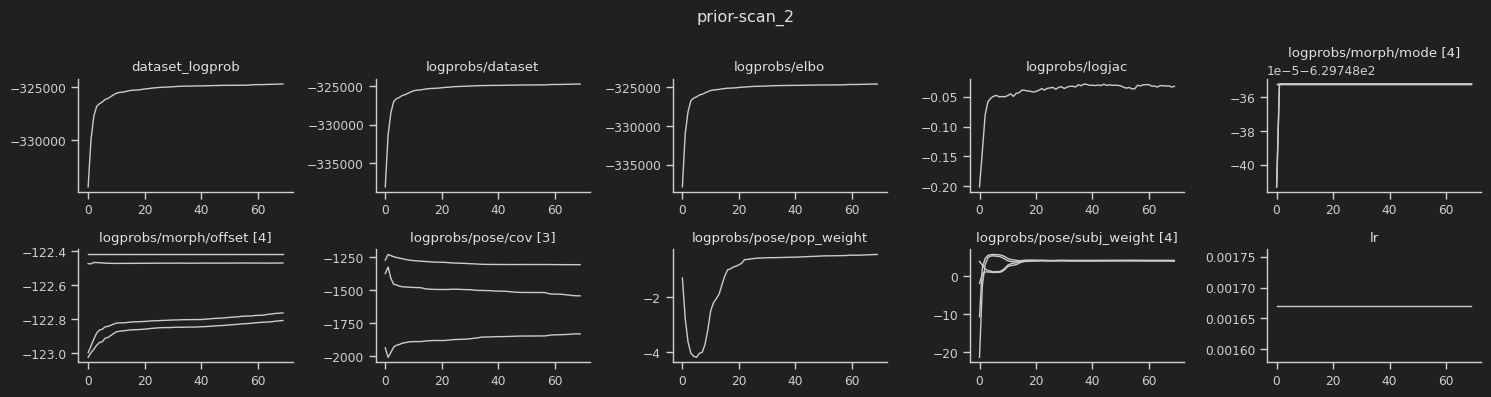

In [5]:
scan_cfg = config.load_config(project.scan("prior-scan") / "scan.yml")
for model_name in scan_cfg["models"]:
    ckpt = methods.load_fit(project.model(model_name))
    fig = viz_models.report_plots(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, None)

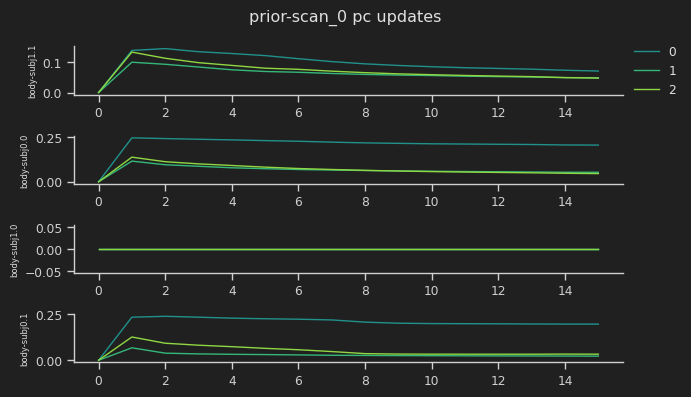

In [9]:
model_name = "prior-scan_0"
scan_name = "prior-scan"
ckpt = methods.load_fit(project.model(model_name))
cfg = config.load_model_config(project.model_config(model_name))
model = instantiation.get_model(cfg)
param_hist = scans.merge_param_hist_with_hyperparams(
    model,
    ckpt["params"],
    ckpt["meta"]["param_hist"])
dataset, keypoint_dataset = scans.load_scan_dataset(project, scan_name)
pal = colors.cts1(int(param_hist.morph.n_dims[0]))
fig, ax = plt.subplots(dataset.n_bodies, 1, figsize=(7, 4))
for i_body, body_name in dataset._body_names.items():
    upd_norms = jla.norm(param_hist.morph.mode_updates[:, i_body], axis = -2)
    for i_mode in range(param_hist.morph.n_dims[0]):
        ax[i_body].plot(upd_norms[:, i_mode], color = pal[i_mode], lw = 1, label = i_mode)
    ax[i_body].set_ylabel(body_name, fontsize = 6)
viz.util.legend(ax[0])
fig.suptitle(f"{model_name} pc updates")
plotter.finalize(fig, None)

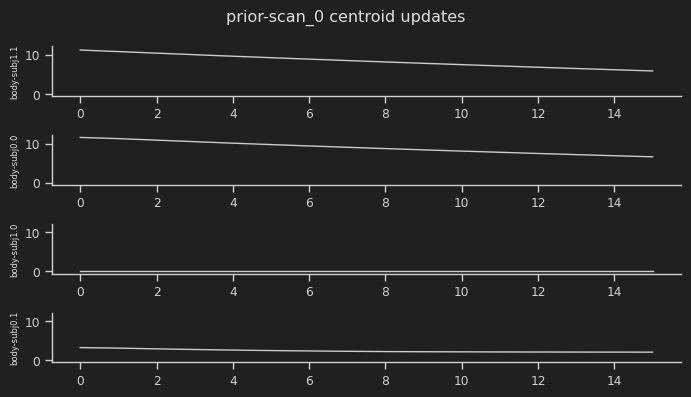

In [7]:
model_name = "prior-scan_0"
scan_name = "prior-scan"
ckpt = methods.load_fit(project.model(model_name))
cfg = config.load_model_config(project.model_config(model_name))
model = instantiation.get_model(cfg)
param_hist = scans.merge_param_hist_with_hyperparams(
    model,
    ckpt["params"],
    ckpt["meta"]["param_hist"])
dataset, keypoint_dataset = scans.load_scan_dataset(project, scan_name)
fig, ax = plt.subplots(dataset.n_bodies, 1, figsize=(7, 4), sharey = True)
for i_body, body_name in dataset._body_names.items():
    upd_norms = jla.norm(param_hist.morph.offset_updates[:, i_body], axis = -1)
    ax[i_body].plot(upd_norms, color = colors.neutral, lw = 1)
    ax[i_body].set_ylabel(body_name, fontsize = 6)
fig.suptitle(f"{model_name} centroid updates")
plotter.finalize(fig, None)

In [6]:
# map `compare` session on to `ref` session, where the two have exact
# frame correspondence
mappings = {"ref": ["subj0.0", "subj0.1"], "compare": ["subj1.0", "subj1.1"]}


scan_cfg = config.load_config(project.scan("prior-scan") / "scan.yml")
dataset = None
ref = defaultdict(list); mapped = defaultdict(list); compare = defaultdict(list)
for model_name in scan_cfg["models"]:
    cfg = config.load_model_config(project.model_config(model_name))
    armature = Armature.from_config(cfg["dataset"])
    model = instantiation.get_model(cfg)
    checkpoint = methods.load_fit(project.model(model_name))

    # all models will have same dataset, even after modification by the fit function
    if dataset is None:
        # load split and non-split versions of the dataset
        dataset = loaders.raw_npy.load(cfg["dataset"])
        dataset_aligned, align_inverse = alignment.align(
            dataset, cfg["alignment"]
        )
        dataset_reduced, reduction_inverse = features.reduce_to_features(
            dataset_aligned, cfg["features"]
        )
        dataset_train = methods.modify_dataset(
            project.model(model_name), dataset_reduced
        )
        _inflate = lambda x: features.inflate(
            x, cfg["features"], reduction_inverse
        )
        inflated_train = _inflate(dataset_train)

        # map from original dataset bodies to sessions in the split dataset
        _body_inv = io_utils.split_body_inv(
            dataset,
            cfg["fit"]["split_all"],
            cfg["fit"]["split_type"],
            cfg["fit"]["split_count"],
        )

        n_mappings = len(mappings["ref"])
        galleries = [
            jnp.stack(list(viz.util.select_frame_gallery(
                inflated_train.get_session(ref_sess), armature, return_ixs=True
            ).values()))
            for ref_sess in mappings["ref"]
        ]

    for i_map in range(n_mappings):
        ref_sess = mappings["ref"][i_map]
        compare_sess = mappings["compare"][i_map]
        pose_ixs = galleries[i_map]
        ref_body = dataset_train.sess_bodies[ref_sess]
        compare_body = dataset_train.sess_bodies[compare_sess]

        # map from compare_sess onto the body of ref_sess and grab pose_ixs
        mapped_reduced = model_util.apply_bodies(
            model.morph,
            checkpoint["params"].morph,
            dataset_train.session_subset([compare_sess], bad_ref_ok=True),
            {compare_sess: ref_body},
        ).get_session(compare_sess)[pose_ixs]
        mapped[model_name].append(_inflate(mapped_reduced))
        ref[model_name].append(inflated_train.get_session(ref_sess)[pose_ixs])
        compare[model_name].append(inflated_train.get_session(compare_sess)[pose_ixs])

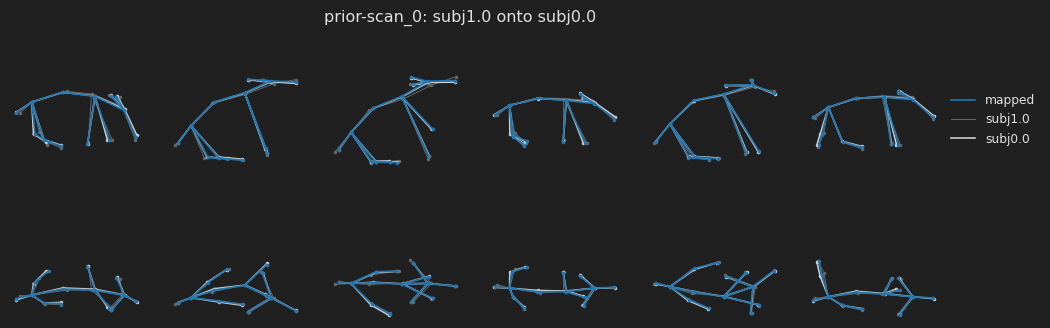

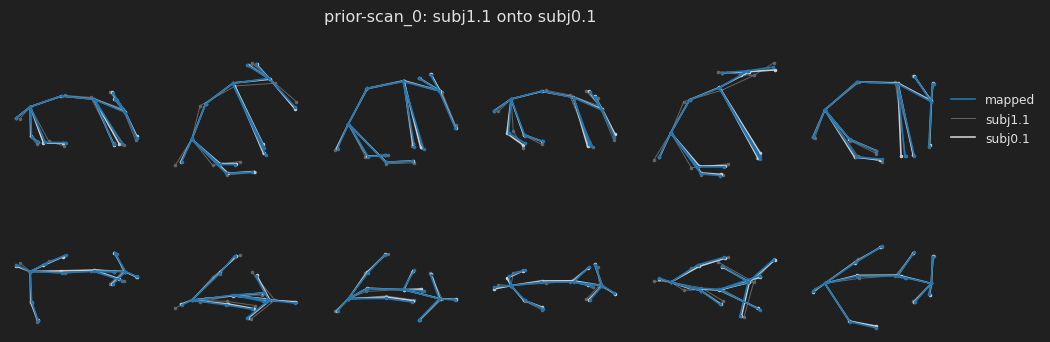

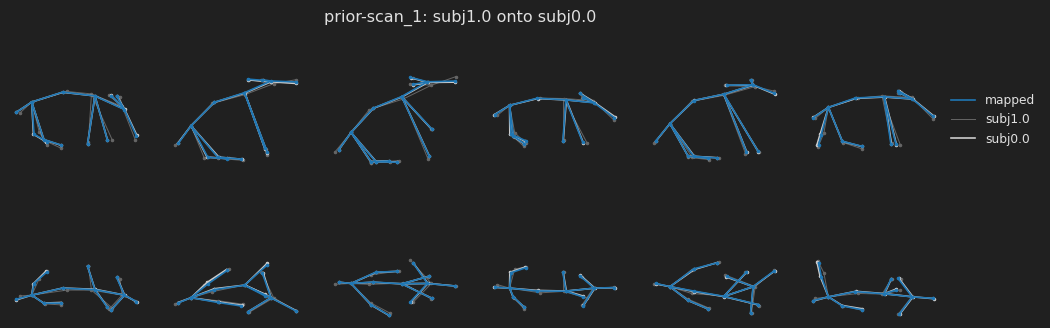

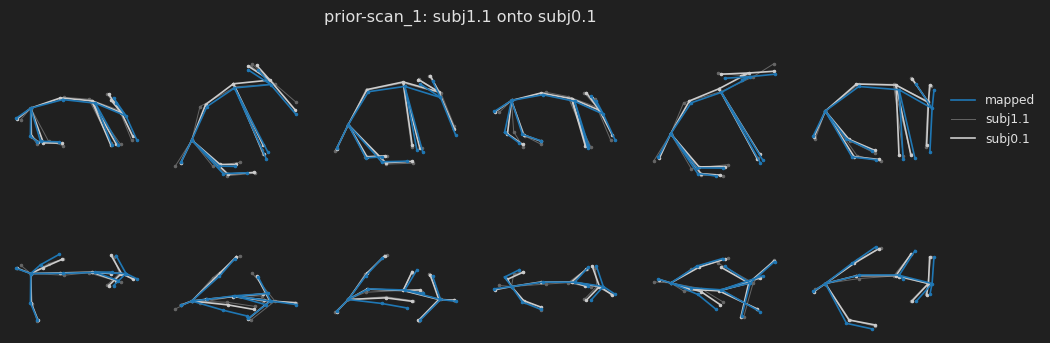

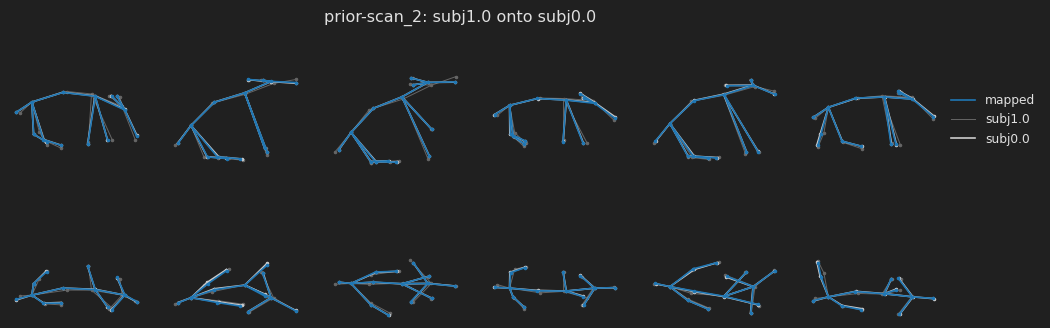

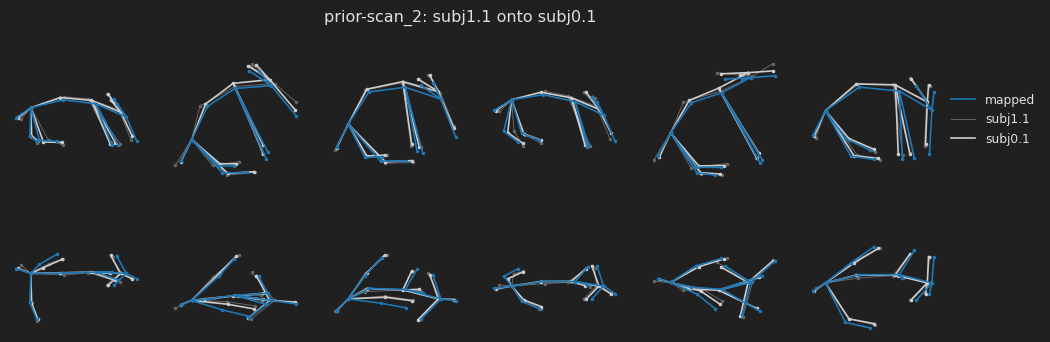

In [7]:
armature = Armature.from_config(cfg["dataset"])
n_mappings = len(mappings["ref"])

for model_name in scan_cfg["models"]:
    for i_map in range(n_mappings):
        gallery = galleries[i_map]
        ref_poses = ref[model_name][i_map]
        compare_poses = compare[model_name][i_map]
        ref_sess = mappings["ref"][i_map]
        mapped_poses = mapped[model_name][i_map]
        comp_session = mappings["compare"][i_map]

        fig, ax = plt.subplots(
            2,
            len(gallery),
            figsize=(len(gallery) * 2, 4),
        )
        for j, ix in enumerate(gallery):
            viz_util.plot_mouse_views(
                ax[:, j],
                mapped_poses[j],
                armature,
                color=colors.C[0],
                label="mapped",
                zorder = 3
            )
            viz_util.plot_mouse_views(
                ax[:, j],
                compare_poses[j],
                armature,
                color=colors.subtle,
                line_kw=dict(lw=0.7),
                label=comp_session,
                zorder=-3,
            )
            viz_util.plot_mouse_views(
                ax[:, j],
                ref_poses[j],
                armature,
                color=colors.neutral,
                label=ref_sess,
                zorder = 0
            )

        viz.util.legend(ax[0, -1])

        for a in ax.ravel():
            viz.util.axes_off(a)

        fig.suptitle(f"{model_name}: {mappings['compare'][i_map]} onto {mappings['ref'][i_map]}")
        plt.show()

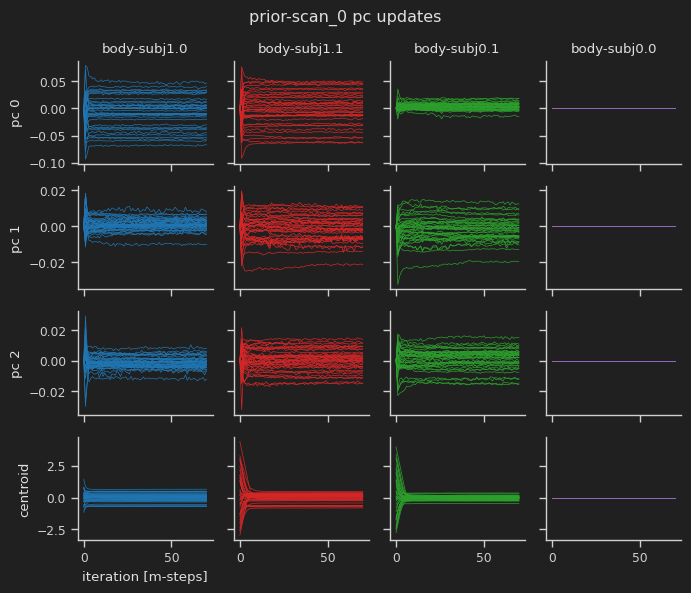

In [10]:
model_name = 'prior-scan_0'
ckpt = methods.load_fit(project.model(model_name))
cfg = config.load_model_config(project.model_config(model_name))
_dataset = loaders.load_dataset(cfg["dataset"])
_dataset = methods.modify_dataset(project.model(model_name), _dataset)
model = instantiation.get_model(cfg)
param_hist = scans.merge_param_hist_with_hyperparams(
    model,
    ckpt["params"],
    ckpt["meta"]["param_hist"])
n_bodies = int(param_hist.morph.n_bodies[0])
n_dims = int(param_hist.morph.n_dims[0])
pal = [colors.C[0], colors.C[2], colors.C[1], colors.C[3]]
fig, ax = plt.subplots(n_dims + 1, n_bodies, figsize=(7, 6), sharex = True, sharey = 'row')
for i_body in range(n_bodies):
    for i_mode in range(n_dims):
        upds = param_hist.morph.mode_updates[:, i_body, :, i_mode]
        ax[i_mode, i_body].plot(upds, color = pal[i_body], lw = 0.5, label = [i_body] + [None] * (upds.shape[-1] - 1))
        ax[0, i_body].set_title(_dataset._body_names[i_body])
        ax[i_mode, 0].set_ylabel(f"pc {i_mode}")
    upds = param_hist.morph.offset_updates[:, i_body, :]
    ax[-1, i_body].plot(upds, color = pal[i_body], lw = 0.5)
        
ax[-1, 0].set_xlabel("iteration [m-steps]")
ax[-1, 0].set_ylabel("centroid")
# viz.util.legend(ax[0, -1])
fig.suptitle(f"{model_name} pc updates")
plotter.finalize(fig, None)

### Replication

In [4]:
model_dir, cfg = create_model(project, 'lrakp_default-replicate', config_overrides = {
    'fit.learning_rate': 1,
    'fit.n_steps': 10,
    'morph.n_dims': 1,
    'pose.wish_var': None,
    'pose.wish_dof': None,
    'pose.n_components': 5,
})
fit_data = methods.fit(
    project.model('lrakp_default-replicate'),
    log_every = 1,)

INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 2395 frames
INFO:root:Adjusting learning rate:1 -> 0.00020876826722338206
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 333311.625
INFO:root:Step 1 : loss = 318919.28125
INFO:root:Step 2 : loss = 318168.5625
INFO:root:Step 3 : loss = 317968.09375
INFO:root:Step 4 : loss = 317831.34375
INFO:root:Step 5 : loss = 317716.375
INFO:root:Step 6 : loss = 317612.375
INFO:root:Step 7 : loss = 317519.09375
INFO:root:Step 8 : loss = 317434.28125
INFO:root:Step 9 : loss = 317365.40625


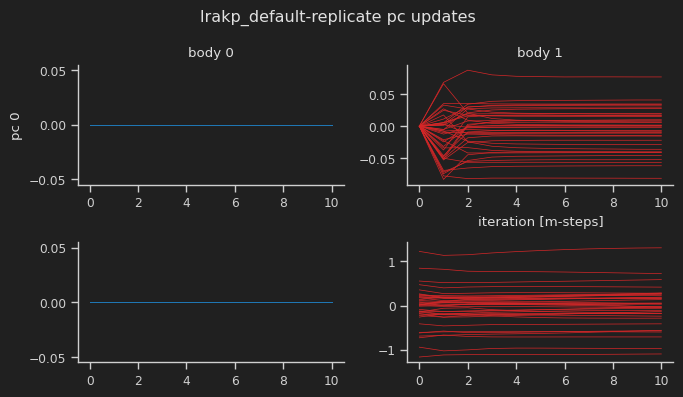

In [35]:
model_name = 'lrakp_default-replicate'
ckpt = methods.load_fit(project.model(model_name))
cfg = config.load_model_config(project.model_config(model_name))
model = instantiation.get_model(cfg)
param_hist = scans.merge_param_hist_with_hyperparams(
    model,
    ckpt["params"],
    ckpt["meta"]["param_hist"])
n_bodies = int(param_hist.morph.n_bodies[0])
n_dims = int(param_hist.morph.n_dims[0])
pal = [colors.C[0], colors.C[2]]
fig, ax = plt.subplots(n_dims + 1, n_bodies, figsize=(7, 4))
for i_body in range(n_bodies):
    for i_mode in range(n_dims):
        upds = param_hist.morph.mode_updates[:, i_body, :, i_mode]
        ax[i_mode, i_body].plot(upds, color = pal[i_body], lw = 0.5, label = [i_body] + [None] * (upds.shape[-1] - 1))
        ax[0, i_body].set_title(f"body {i_body}")
        ax[i_mode, 0].set_ylabel(f"pc {i_mode}")
    upds = param_hist.morph.offset_updates[:, i_body, :]
    ax[-1, i_body].plot(upds, color = pal[i_body], lw = 0.5)
        
ax[0, -1].set_xlabel("iteration [m-steps]")
# viz.util.legend(ax[0, -1])
fig.suptitle(f"{model_name} pc updates")
plotter.finalize(fig, None)

In [19]:
param_hist.morph.n_dims

Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32, weak_type=True)

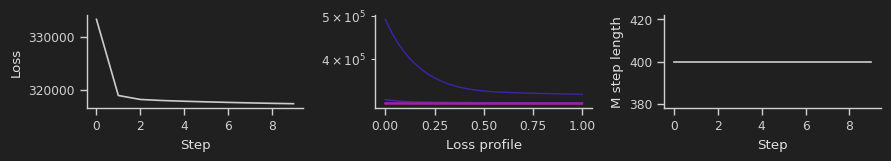

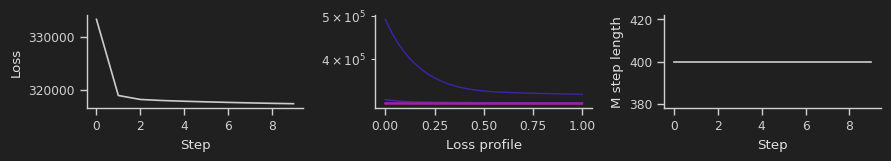

In [12]:
checkpoint = methods.load_fit(project.model('lrakp_default-replicate'))

def em_loss(loss_hist, mstep_losses, mstep_relative = True):
    fig, ax = plt.subplots(figsize = (9, 1.7), ncols = 3)
    
    pal = sns.hls_palette(len(mstep_losses) * 5, h = 0.7, l = 0.4)[:len(mstep_losses)]

    mstep_lengths = []
    for i in range(0, len(mstep_losses)):
        
        if np.any(~np.isfinite(mstep_losses[i])):
            curr_loss = mstep_losses[i][:np.argmax(~np.isfinite(mstep_losses[i]))]
            if len(curr_loss) == 0: continue
        else:
            curr_loss = mstep_losses[i]
        mstep_lengths.append(len(curr_loss))
        
        if mstep_relative:
            plot_y = (curr_loss - curr_loss.min()) / (curr_loss.max() - curr_loss.min())
        else: plot_y = curr_loss

        ax[1].plot(
            np.linspace(0, 1, len(curr_loss)),
            plot_y,
            color = pal[i], lw = 1)
        
    if not mstep_relative:
        ax[1].set_yscale('log')
        
    ax[0].plot(loss_hist, colors.neutral)
    if loss_hist.max() > 2 * loss_hist[0]:
        ax[0].set_ylim(None, 2 * loss_hist[0])
    ax[2].plot(np.arange(len(mstep_lengths)), mstep_lengths, colors.neutral)

    ax[1].set_xlabel("Loss profile")
    ax[2].set_ylabel("M step length")
    ax[2].set_xlabel("Step")
    ax[0].set_ylabel("Loss")
    ax[0].set_xlabel("Step")
    
    fig.tight_layout()
    sns.despine()
    return fig

em_loss(checkpoint['meta']['loss'], checkpoint['meta']['mstep_losses'], mstep_relative=False)

In [36]:
# map `compare` session on to `ref` session, where the two have exact
# frame correspondence
mappings = {"ref": ["subj0"], "compare": ["subj1"]}

model_name = 'lrakp_default-replicate'
ref = defaultdict(list); mapped = defaultdict(list); compare = defaultdict(list)

cfg = config.load_model_config(project.model_config(model_name))
armature = Armature.from_config(cfg["dataset"])
model = instantiation.get_model(cfg)
checkpoint = methods.load_fit(project.model(model_name))


# load split and non-split versions of the dataset
dataset = loaders.raw_npy.load(cfg["dataset"])
dataset_aligned, align_inverse = alignment.align(
    dataset, cfg["alignment"]
)
dataset_reduced, reduction_inverse = features.reduce_to_features(
    dataset_aligned, cfg["features"]
)
# in case this was a split fit
dataset_train = methods.modify_dataset(
    project.model(model_name), dataset_reduced
)
_inflate = lambda x: features.inflate(
    x, cfg["features"], reduction_inverse
)
inflated_train = _inflate(dataset_train)


n_mappings = len(mappings["ref"])
galleries = [
    jnp.stack(list(viz.util.select_frame_gallery(
        inflated_train.get_session(ref_sess), armature, return_ixs=True
    ).values()))
    for ref_sess in mappings["ref"]
]

for i_map in range(n_mappings):
    ref_sess = mappings["ref"][i_map]
    compare_sess = mappings["compare"][i_map]
    pose_ixs = galleries[i_map]
    ref_body = dataset_train.sess_bodies[ref_sess]
    compare_body = dataset_train.sess_bodies[compare_sess]

    # map from compare_sess onto the body of ref_sess and grab pose_ixs
    mapped_reduced = model_util.apply_bodies(
        model.morph,
        checkpoint["params"].morph,
        dataset_train.session_subset([compare_sess], bad_ref_ok=True),
        {compare_sess: ref_body},
    ).get_session(compare_sess)[pose_ixs]
    mapped[model_name].append(_inflate(mapped_reduced))
    ref[model_name].append(inflated_train.get_session(ref_sess)[pose_ixs])
    compare[model_name].append(inflated_train.get_session(compare_sess)[pose_ixs])

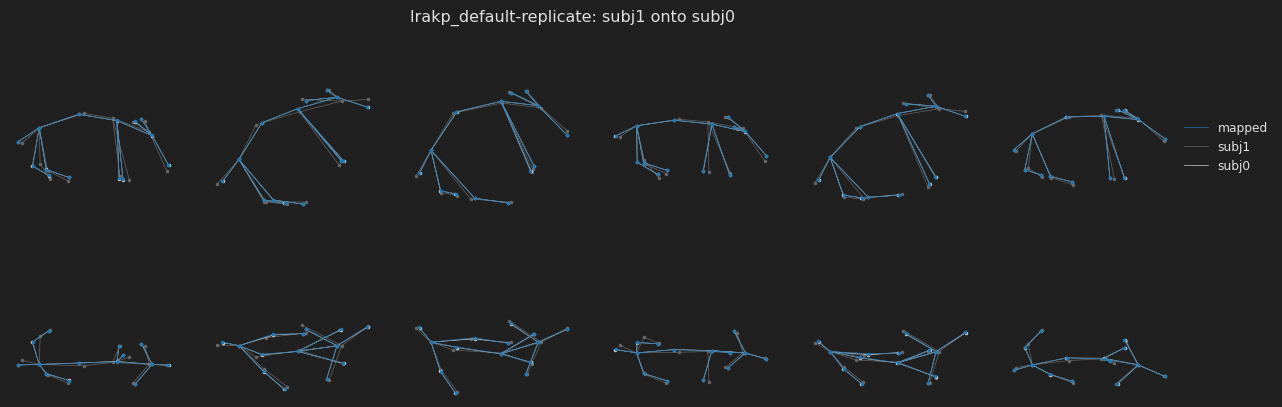

In [40]:
armature = Armature.from_config(cfg["dataset"])
n_mappings = len(mappings["ref"])

for i_map in range(n_mappings):
    gallery = galleries[i_map]
    ref_poses = ref[model_name][i_map]
    compare_poses = compare[model_name][i_map]
    ref_sess = mappings["ref"][i_map]
    mapped_poses = mapped[model_name][i_map]
    comp_session = mappings["compare"][i_map]

    fig, ax = plt.subplots(
        2,
        len(gallery),
        figsize=(len(gallery) * 2.5, 5),
    )
    for j, ix in enumerate(gallery):
        viz_util.plot_mouse_views(
            ax[:, j],
            mapped_poses[j],
            armature,
            color=colors.C[0],
            label="mapped",
            line_kw=dict(lw=0.5),
            zorder = 3
        )
        viz_util.plot_mouse_views(
            ax[:, j],
            compare_poses[j],
            armature,
            color=colors.subtle,
            line_kw=dict(lw=0.5),
            label=comp_session,
            zorder=-3,
        )
        viz_util.plot_mouse_views(
            ax[:, j],
            ref_poses[j],
            armature,
            color=colors.neutral,
            label=ref_sess,
            line_kw=dict(lw=0.5),
            zorder = 0
        )

    viz.util.legend(ax[0, -1])

    for a in ax.ravel():
        viz.util.axes_off(a)

    fig.suptitle(f"{model_name}: {mappings['compare'][i_map]} onto {mappings['ref'][i_map]}")
    plt.show()

In [ ]:
fit_data = methods.fit(
    project.model('split-replicate'),
    log_every = 1,)